## Importing required packages

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# API

With no API key: 240 requests per minute, per IP address. 1,000 requests per day, per IP address.

With an API key: 240 requests per minute, per key. 120,000 requests per day, per key.

Your api key can be found here: https://open.fda.gov/apis/authentication/

In [2]:
# Insert your API key in the string('') below that is obtained from above link 
api_key = ''

# Recall database
Parameter:
- recall firm (required)
- product code (optional)
- date_start & date_end (optional)
- other_para & other_para_value 
(For using the other_para, please use the variables in searchable fields: https://open.fda.gov/apis/device/recall/searchable-fields/)

In [3]:
def recall_extract_by_firm(recall_firm = None,date_start = None, date_end = None, other_para = None, other_para_value = None, limit = 1000):
    URL = "https://api.fda.gov/device/recall.json?search="
    if recall_firm != None:
        URL += f"recalling_firm:'{recall_firm}'"
        if (date_start != None) and (date_end != None):
            URL += f"+AND+event_date_initiated:[{date_start}+TO+{date_end}]"
        if (other_para != None) and (other_para_value != None):
            URL += f"+AND+{other_para}:'{other_para_value}'"
            
    URL += f"&limit={limit}"
    json_data = requests.get(URL).json()
    data = pd.json_normalize(json_data,'results')
    
    if json_data['meta']['results']['total'] > 1000:
        skip_data = pd.DataFrame()
        num = 1000
        while num < json_data['meta']['results']['total']:
            TEM_URL = URL + f"&skip={num}"
            skip_json_data = requests.get(TEM_URL).json()
            try:
                TEM_data = pd.json_normalize(skip_json_data,'results')
                skip_data = pd.concat([skip_data,TEM_data])
            except KeyError:
                pass
            num += 1000
        return skip_data
    if 'skip_data' in globals():
        data.append(skip_data)
    
    data = data[data['recalling_firm'].str.lower().str.contains(f"{recall_firm.replace('+',' ').lower()}")]
    data.reset_index(inplace=True, drop=True)

    df = pd.DataFrame()
    df['Recall_Number'] = data['product_res_number']
    df['Firm_Name/Manufacturer'] = data['recalling_firm']
    df['Product'] = data['product_description']
    df['Product_Code'] = data['product_code']
    df['Recall_Initiated_By_Firm'] = data['event_date_initiated']
    df['Create_Date'] = data['event_date_created']
    df['Event_Date_Posted'] = data['event_date_posted']
    df['Termination_Date'] = data['event_date_terminated']
    df['Root_Cause_Description'] = data['root_cause_description']
    df['Recall_Status'] = data['recall_status']
    df['Action'] = data['action']
    df['Recall_Class'] = data['openfda.device_class']
    df['Recall_Reason'] = data['reason_for_recall']
    

    return df

# Extract the data for any firm
Values that can be modified below:

    manufacture_name

    date_start

    date_end

In [4]:
recall_edwards = recall_extract_by_firm(recall_firm='edwards+lifesciences',date_start = '2018-01-01', date_end = '2022-04-30')

recall_abbott = recall_extract_by_firm(recall_firm='abbott+laboratories',date_start = '2018-01-01', date_end = '2022-04-30')

recall_stjude = recall_extract_by_firm(recall_firm='st.+jude',date_start = '2018-01-01', date_end = '2022-04-30')

recall_medtronic = recall_extract_by_firm(recall_firm='medtronic',date_start = '2018-01-01', date_end = '2022-04-30')

recall_livanova = recall_extract_by_firm(recall_firm='livanova',date_start = '2018-01-01', date_end = '2022-04-30')

recall_boston_scientific = recall_extract_by_firm(recall_firm='boston+scientific',date_start = '2018-01-01', date_end = '2022-04-30')

In [6]:
#combining all the competitors for further analysis

recall=pd.concat([recall_abbott, recall_stjude, recall_medtronic, recall_livanova, recall_boston_scientific])

# Pre-processing

In [8]:
recall.loc[recall['Firm_Name/Manufacturer'].str.contains('Abbott'), 'Firm_Name/Manufacturer'] = 'Abbott Laboratories'
recall.loc[recall['Firm_Name/Manufacturer'].str.contains('ABBOTT'), 'Firm_Name/Manufacturer'] = 'Abbott Laboratories'


recall.loc[recall['Firm_Name/Manufacturer'].str.contains('Boston'), 'Firm_Name/Manufacturer'] = 'Boston Scientific'
recall.loc[recall['Firm_Name/Manufacturer'].str.contains('BOSTON'), 'Firm_Name/Manufacturer'] = 'Abbott Laboratories'


recall.loc[recall['Firm_Name/Manufacturer'].str.contains('Medtronic'), 'Firm_Name/Manufacturer'] = 'Medtronic'
recall.loc[recall['Firm_Name/Manufacturer'].str.contains('MEDTRONIC'), 'Firm_Name/Manufacturer'] = 'Medtronic'


recall.loc[recall['Firm_Name/Manufacturer'].str.contains('LivaNova'), 'Firm_Name/Manufacturer'] = 'LivaNova'
recall.loc[recall['Firm_Name/Manufacturer'].str.contains('LIVANOVA'), 'Firm_Name/Manufacturer'] = 'Abbott Laboratories'


recall.loc[recall['Firm_Name/Manufacturer'].str.contains('St. Jude'), 'Firm_Name/Manufacturer'] = 'St. Jude Medical'
recall.loc[recall['Firm_Name/Manufacturer'].str.contains('ST. JUDE'), 'Firm_Name/Manufacturer'] = 'Abbott Laboratories'



### Export the file to local system

In [9]:
from pathlib import Path
filepath = Path('') #Enter the file path here
filepath.parent.mkdir(parents=True, exist_ok=True)
recall.to_csv(filepath)

# Recall Class

Risk based classification system for all devices

    1 = Class I (low to moderate risk)

    2 = Class II (moderate to high risk)

    3 = Class III (high risk)

    U = Unclassified

    N = Not classified

    F = HDE

In [10]:
recall['Recall_Class'].value_counts()

2    623
3    229
1     36
N      2
f      2
U      1
Name: Recall_Class, dtype: int64

# Exploratory Analysis

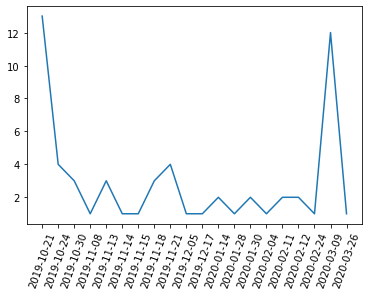

In [14]:
df_group=recall.groupby(['Recall_Initiated_By_Firm']).size()
plt.xticks(rotation=70)
plt.plot(df_group[80:100].index, df_group[80:100].values) #Change the values to check the time seies in for other time periods

Firm_Name/Manufacturer
Medtronic              544
Boston Scientific      242
Abbott Laboratories     52
LivaNova                46
St. Jude Medical        11
dtype: int64


<BarContainer object of 5 artists>

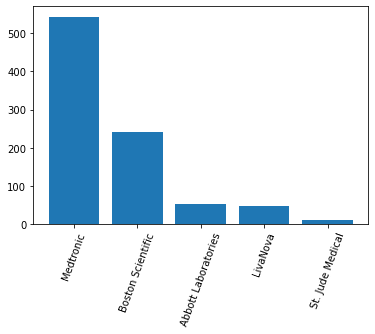

In [15]:
df_group=recall.groupby(['Firm_Name/Manufacturer']).size().sort_values(ascending=False)
print(df_group)
plt.xticks(rotation=70)
plt.bar(df_group.index, df_group.values)

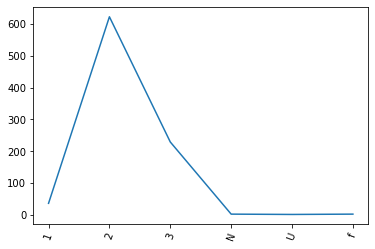

In [16]:
#recall.groupby(['Root_Cause_Description','Recall_Class']).size().sort_values(ascending=False).to_frame()[0:20]

df_class=recall.groupby(['Recall_Class']).size()
plt.xticks(rotation=70)
plt.plot(df_class[0:30].index, df_class[0:30].values)

/Users/sahithimuddana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Product Code - Edwards')

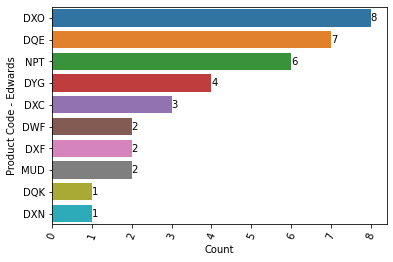

In [17]:
ax=sns.barplot(recall_edwards["Product_Code"].sort_values(ascending=True).value_counts()[0:50],recall_edwards["Product_Code"].sort_values(ascending=True).value_counts()[0:50].index)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=70)
plt.xlabel("Count")
plt.ylabel("Product Code - Edwards")

/Users/sahithimuddana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Product Code - Abbott')

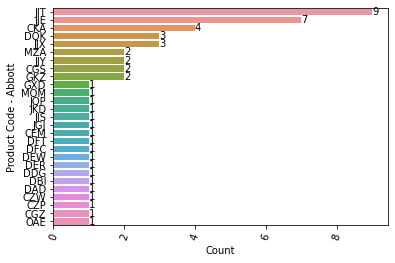

In [18]:
ax=sns.barplot(recall_abbott["Product_Code"].sort_values(ascending=True).value_counts()[0:50],recall_abbott["Product_Code"].sort_values(ascending=True).value_counts()[0:50].index)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=70)
plt.xlabel("Count")
plt.ylabel("Product Code - Abbott")

/Users/sahithimuddana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Product Code - St.Jude')

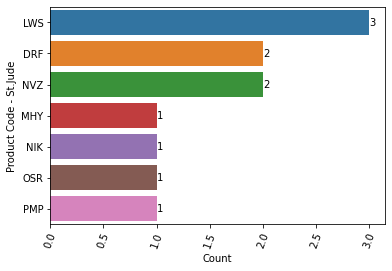

In [19]:
ax=sns.barplot(recall_stjude["Product_Code"].sort_values(ascending=True).value_counts()[0:50],recall_stjude["Product_Code"].sort_values(ascending=True).value_counts()[0:50].index)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=70)
plt.xlabel("Count")
plt.ylabel("Product Code - St.Jude")

/Users/sahithimuddana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Product Code - Livanova')

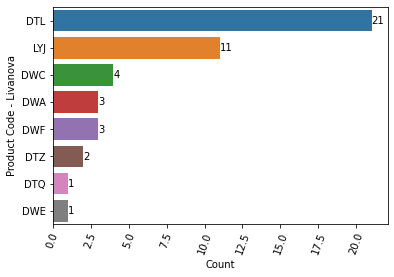

In [20]:
ax=sns.barplot(recall_livanova["Product_Code"].sort_values(ascending=True).value_counts()[0:50],recall_livanova["Product_Code"].sort_values(ascending=True).value_counts()[0:50].index)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=70)
plt.xlabel("Count")
plt.ylabel("Product Code - Livanova")

In [21]:
sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale = 2)

/Users/sahithimuddana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Product Code - Medtronic')

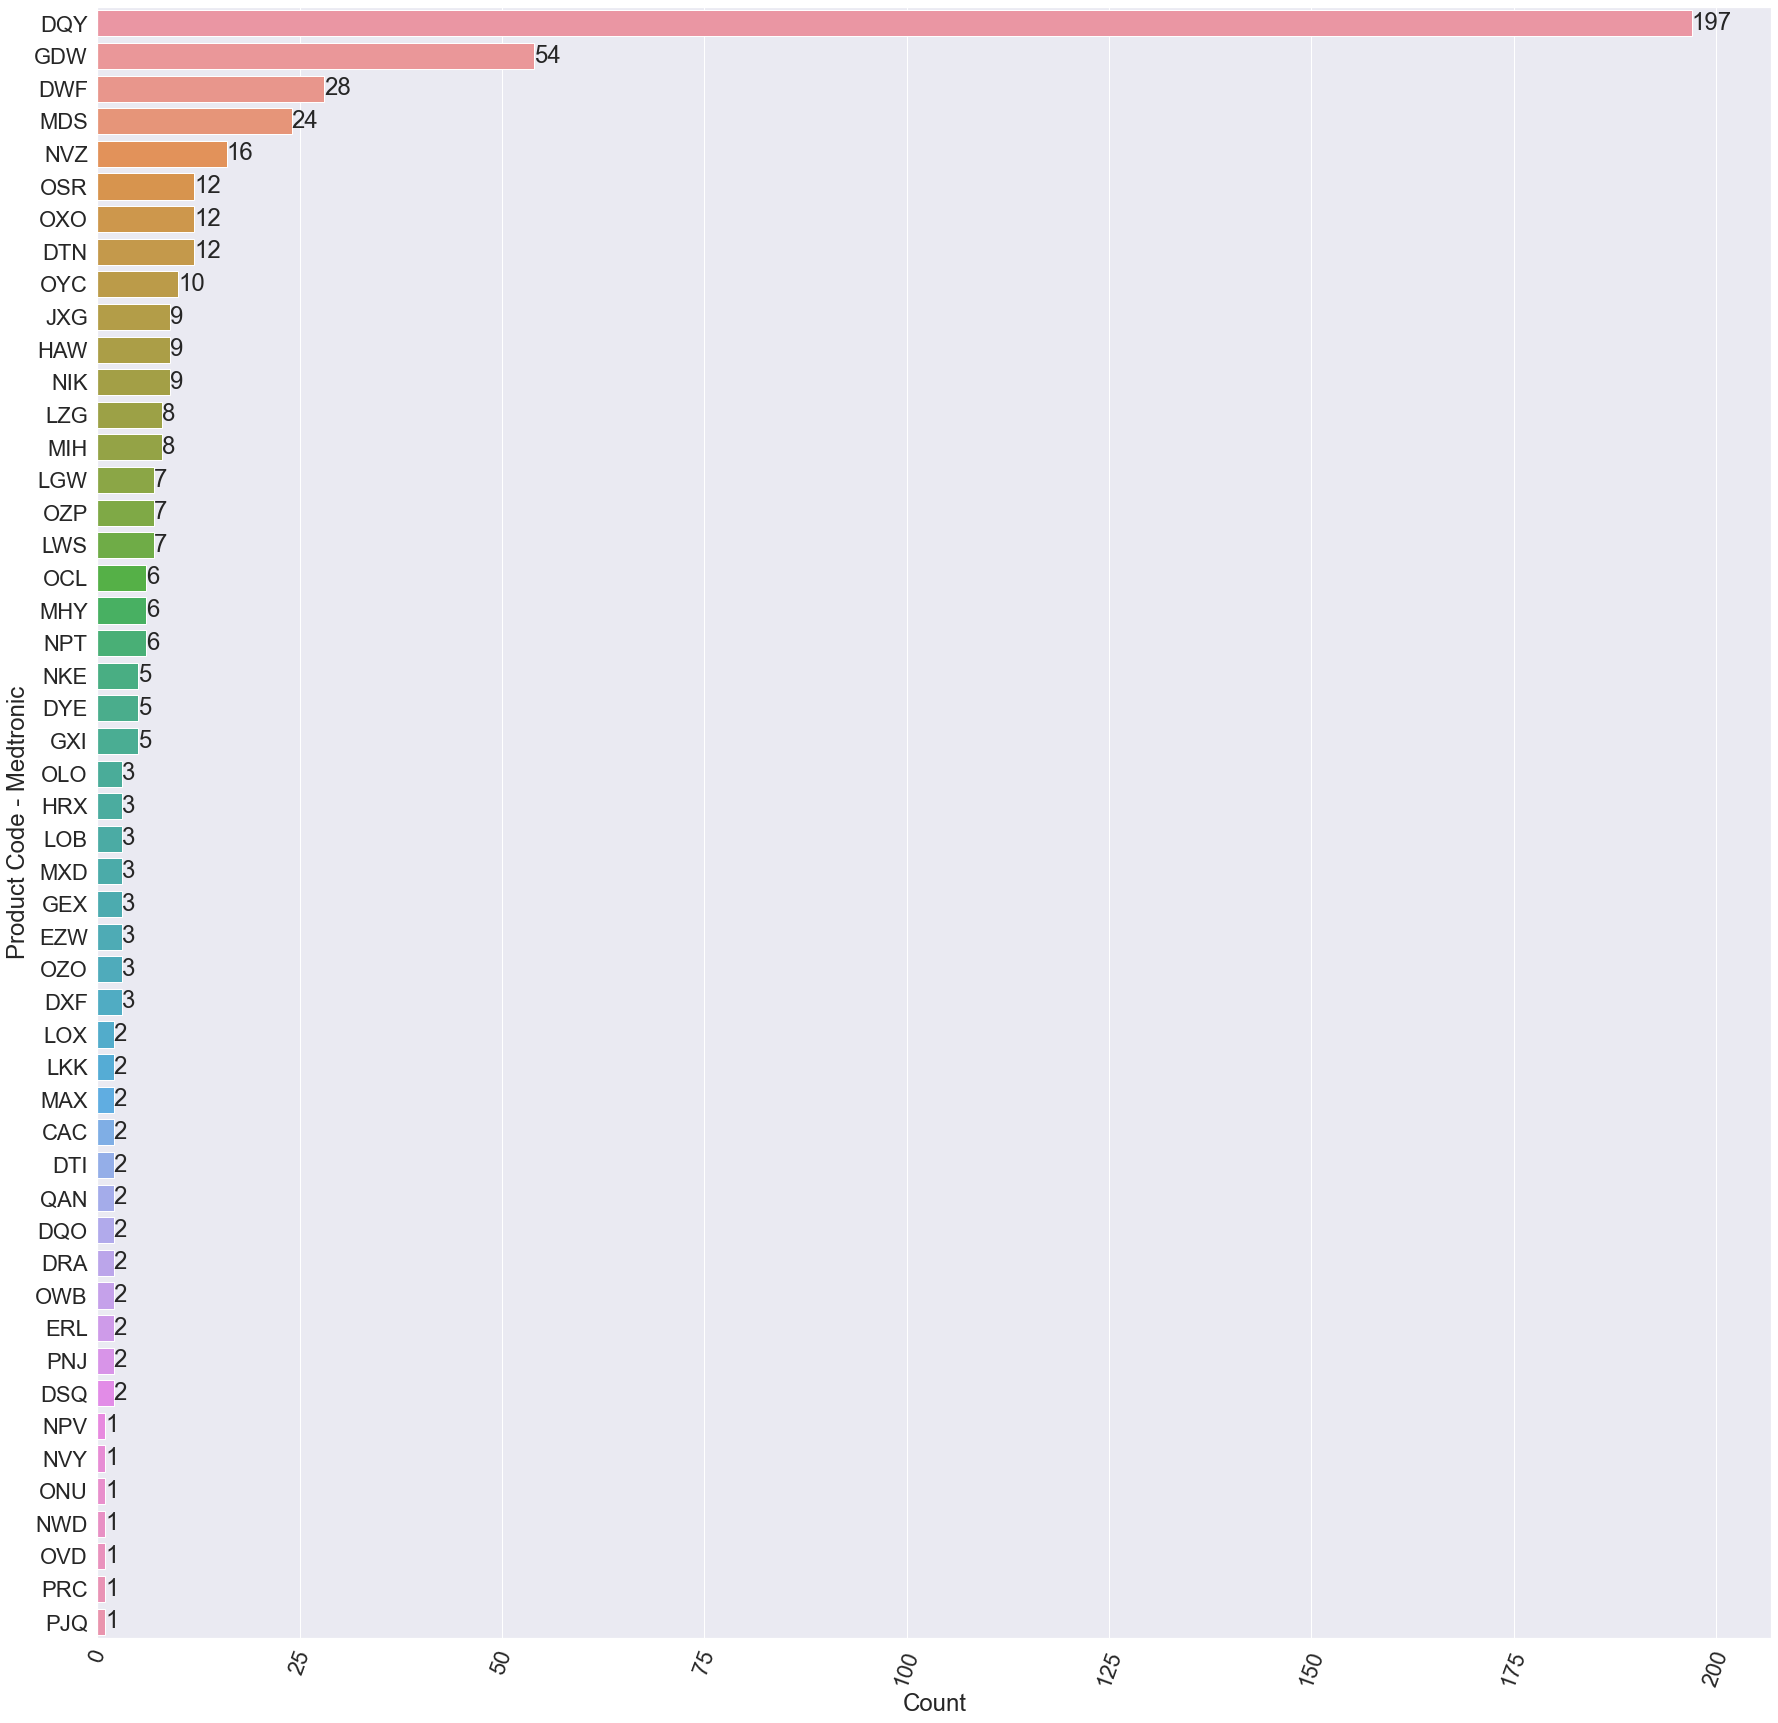

In [22]:
ax=sns.barplot(recall_medtronic["Product_Code"].sort_values(ascending=True).value_counts()[0:50],recall_medtronic["Product_Code"].sort_values(ascending=True).value_counts()[0:50].index)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=70)
plt.xlabel("Count")
plt.ylabel("Product Code - Medtronic")

/Users/sahithimuddana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Product Code - Boston Scientific')

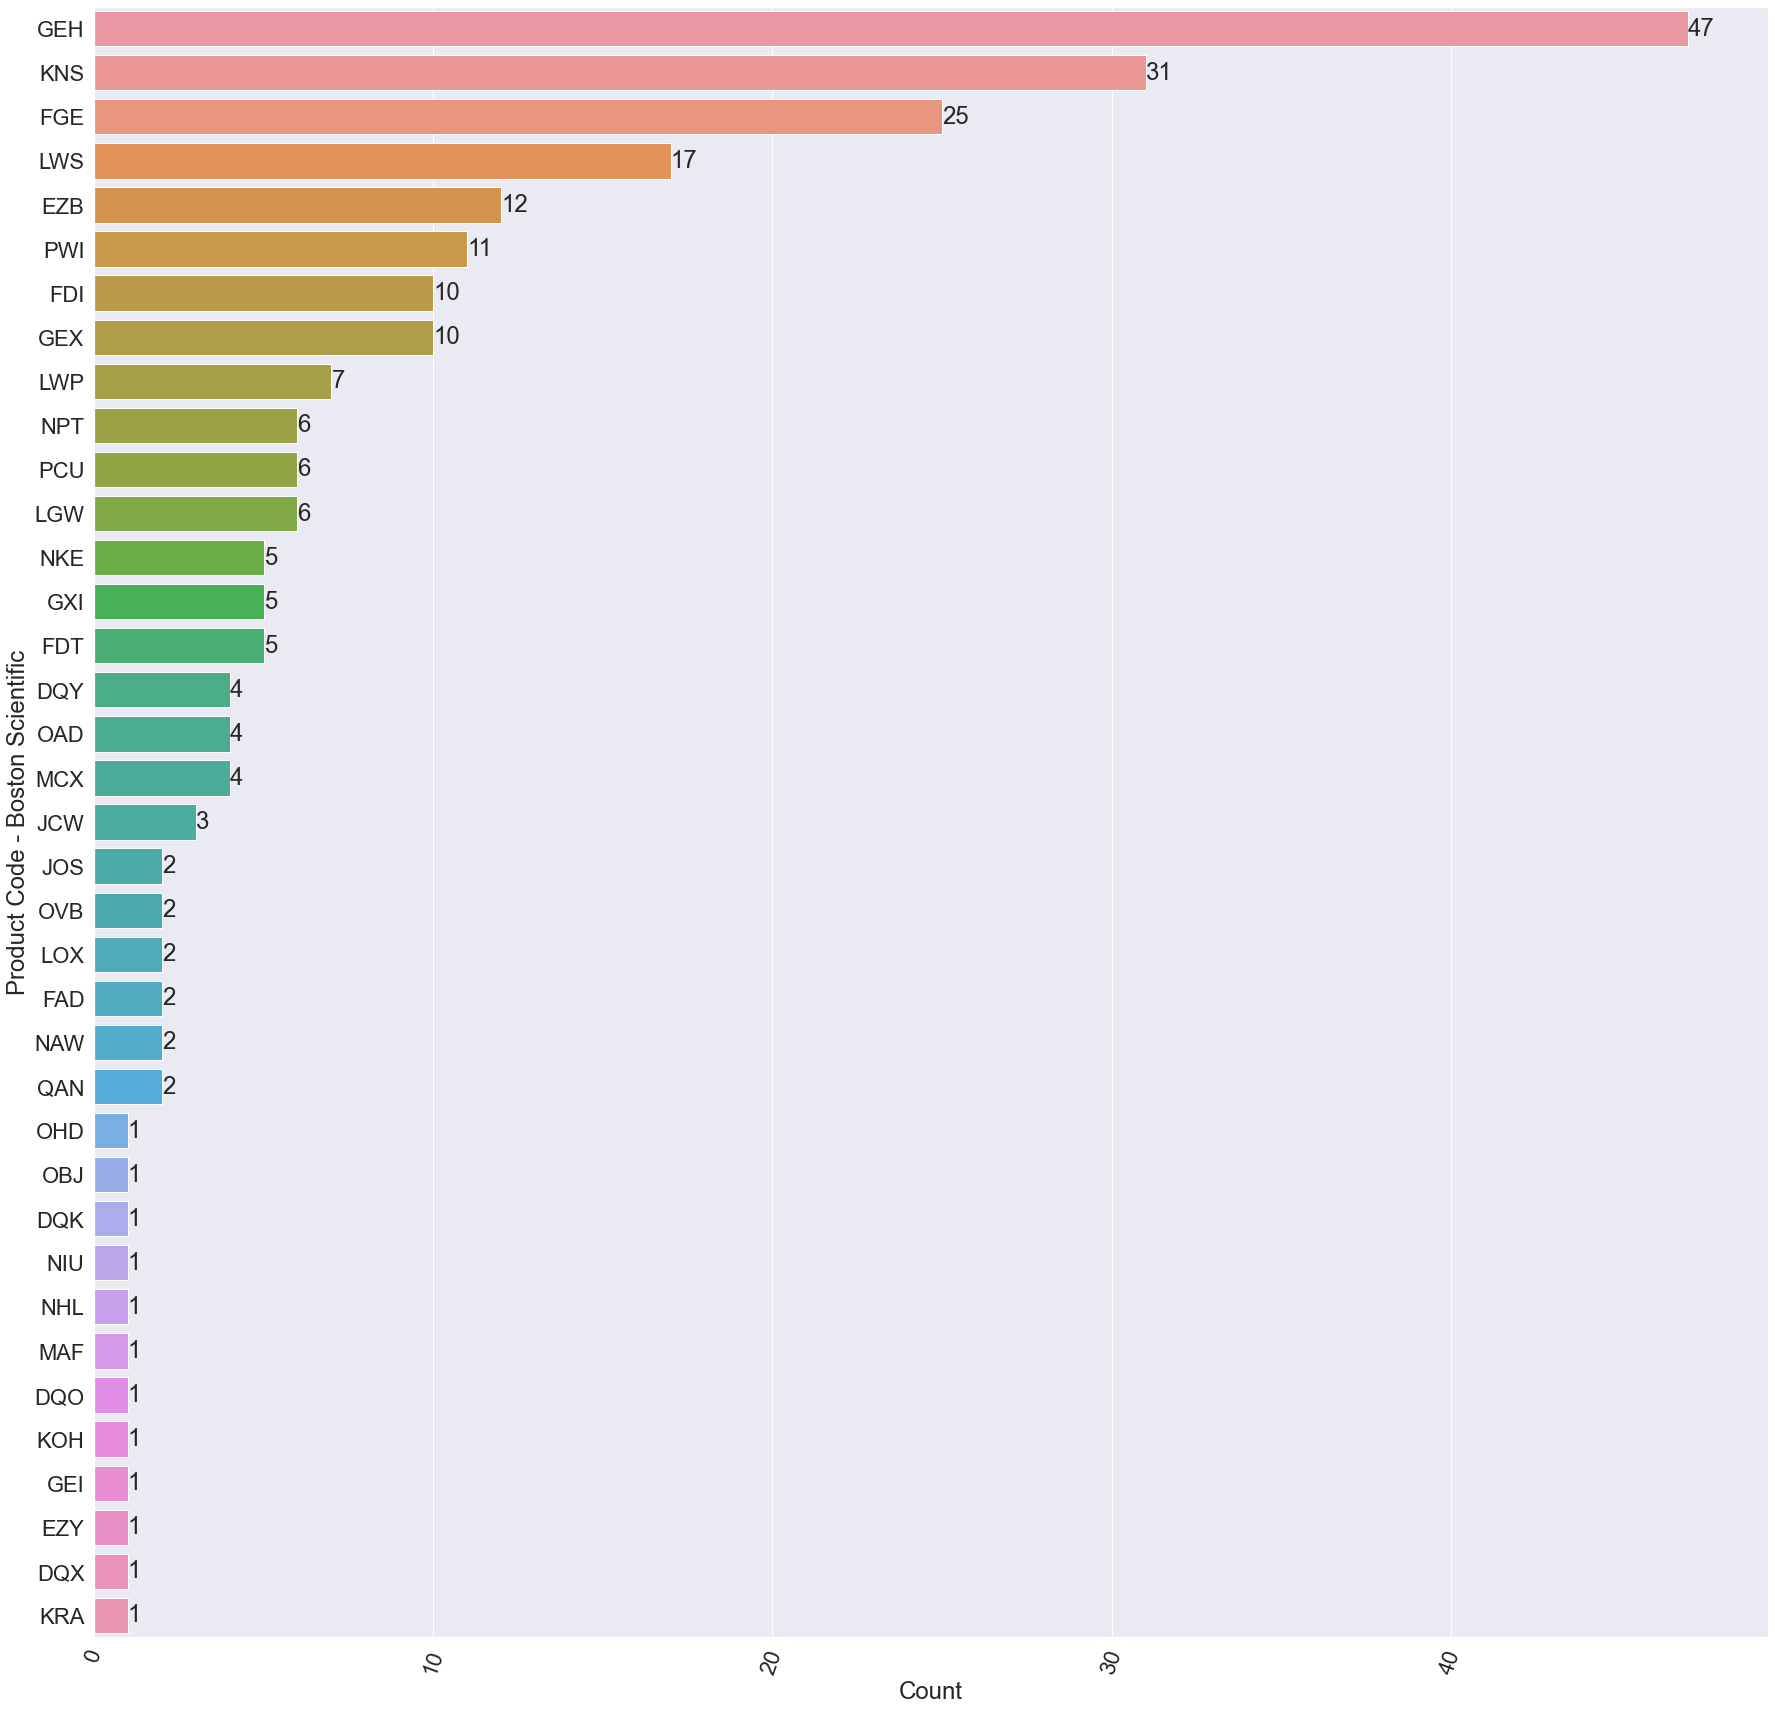

In [23]:
ax=sns.barplot(recall_boston_scientific["Product_Code"].sort_values(ascending=True).value_counts()[0:50],recall_boston_scientific["Product_Code"].sort_values(ascending=True).value_counts()[0:50].index)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=70)
plt.xlabel("Count")
plt.ylabel("Product Code - Boston Scientific")

/Users/sahithimuddana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Product Code - Competitors')

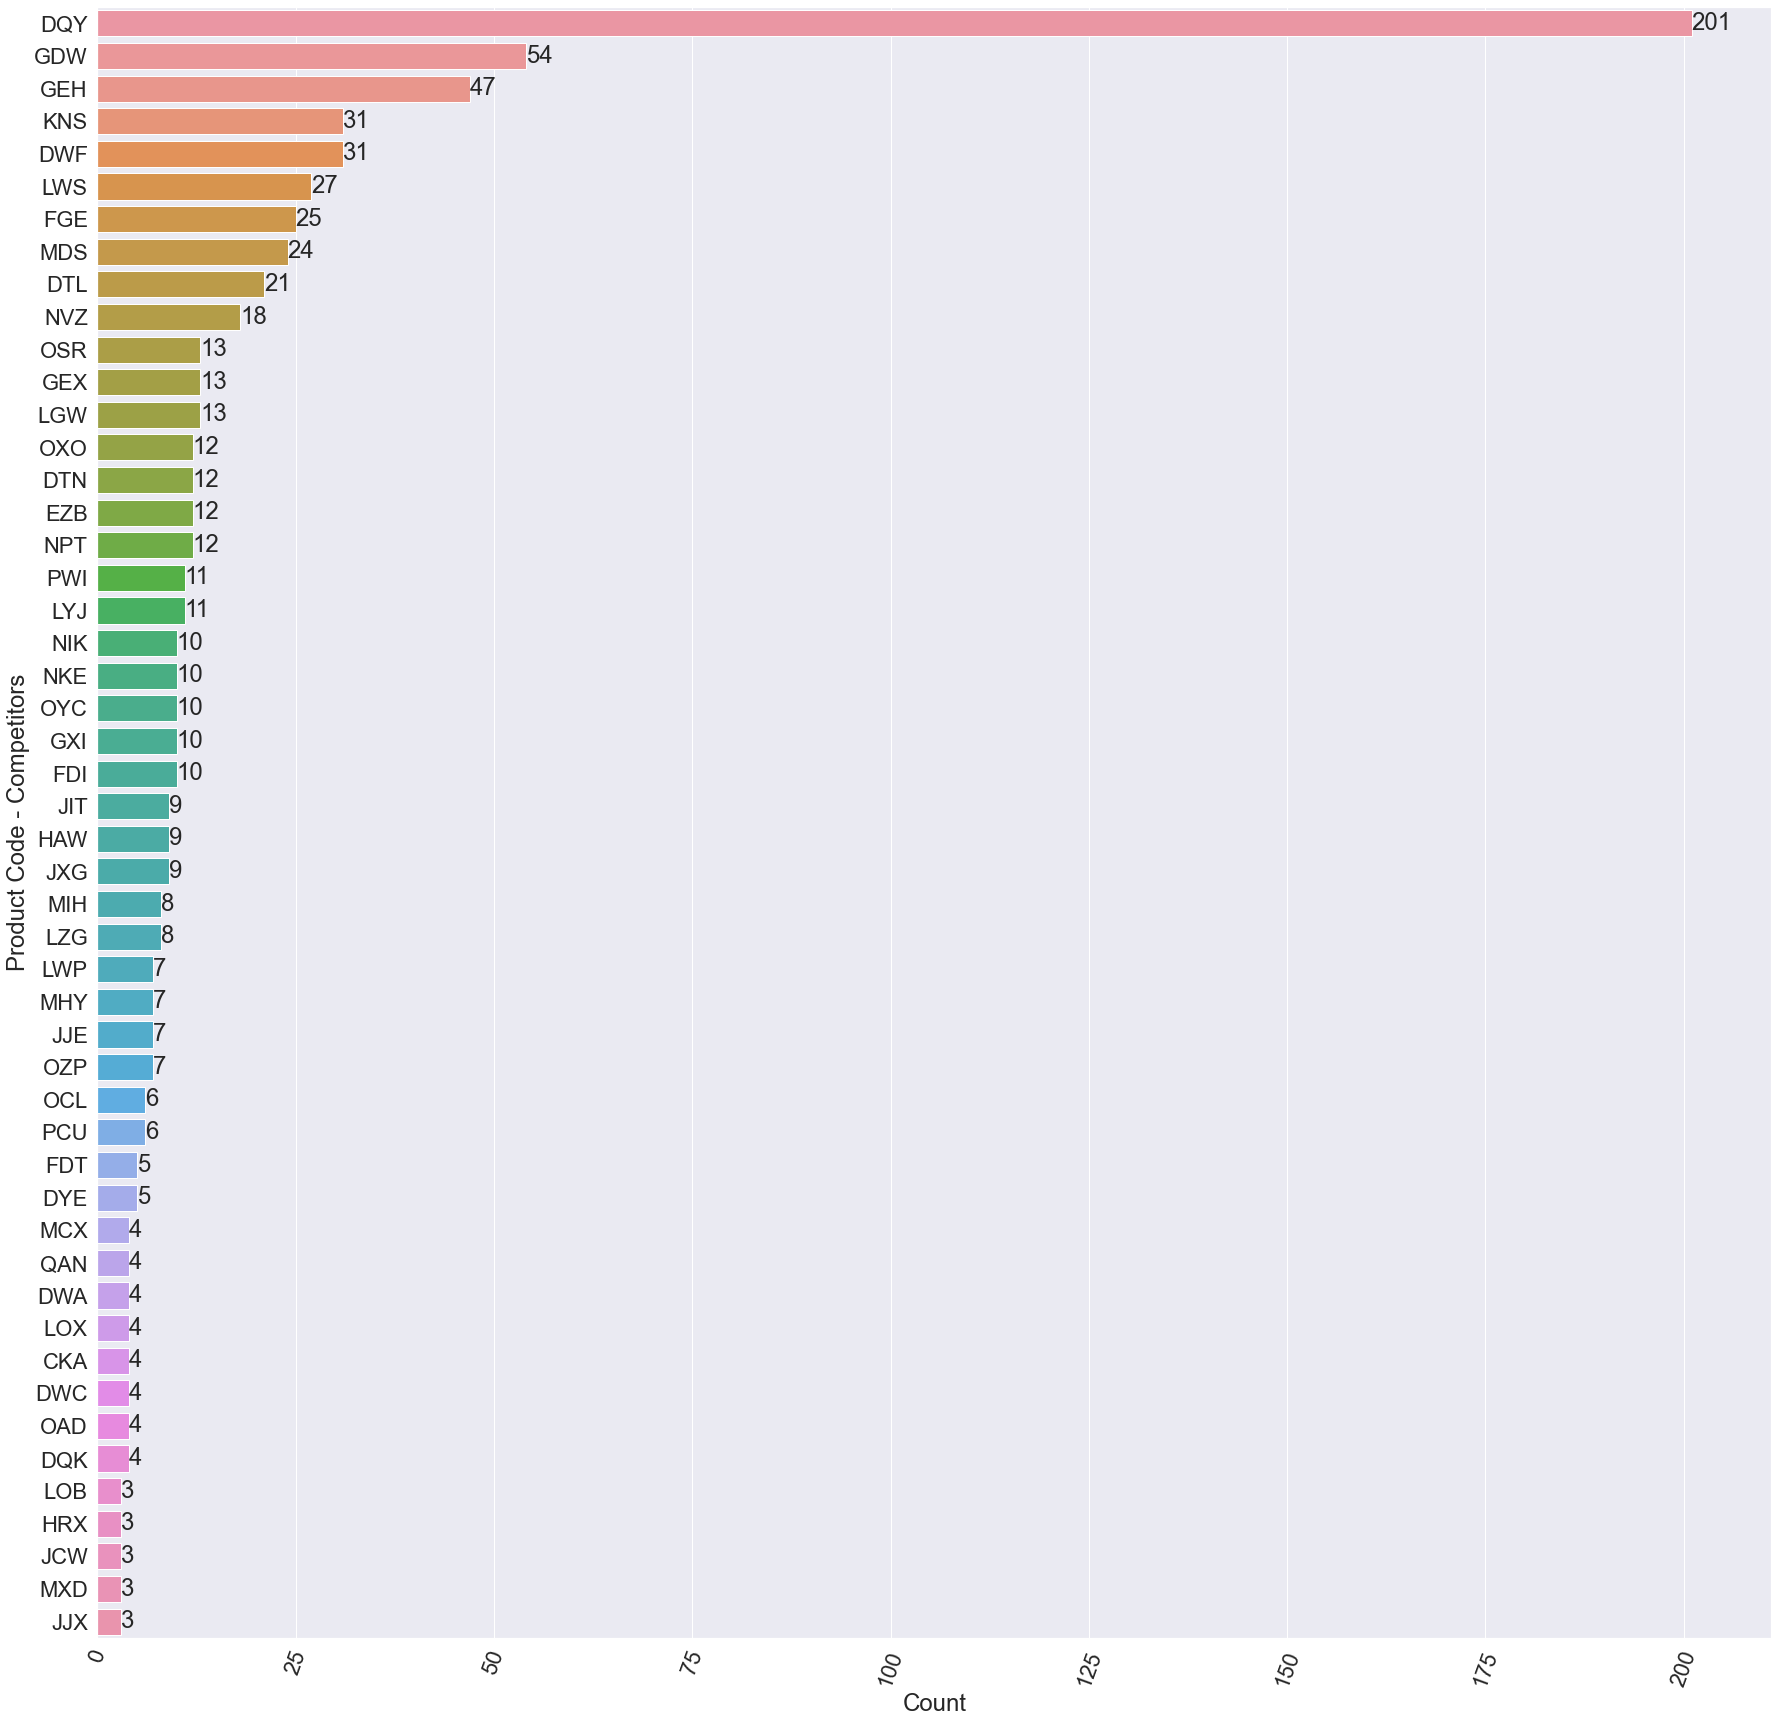

In [24]:
ax=sns.barplot(recall["Product_Code"].sort_values(ascending=True).value_counts()[0:50],recall["Product_Code"].sort_values(ascending=True).value_counts()[0:50].index)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=70)
plt.xlabel("Count")
plt.ylabel("Product Code - Competitors")

# Root Cause for the recalls

In [25]:
rootcause_DQY=recall[recall['Product_Code']=='DQY']['Root_Cause_Description']
rootcause_DQY.value_counts().to_frame()

,Root_Cause_Description
Under Investigation by firm,193
Process control,6
Labeling False and Misleading,2


In [26]:
rootcause1=recall[recall['Product_Code']==recall["Product_Code"].sort_values(ascending=True).value_counts().
                       index[1]]['Root_Cause_Description']
rootcause1.value_counts().to_frame()

,Root_Cause_Description
Process control,54


In [27]:
rootcause2=recall[recall['Product_Code']==recall["Product_Code"].sort_values(ascending=True).value_counts().
                       index[2]]['Root_Cause_Description']
rootcause2.value_counts().to_frame()

,Root_Cause_Description
Under Investigation by firm,36
Nonconforming Material/Component,10
Process design,1


In [28]:
recall.groupby(['Product_Code','Root_Cause_Description']).size().sort_values(ascending=False).to_frame()

0
Product_Code Root_Cause_Description               
DQY          Under Investigation by firm       193
GDW          Process control                    54
GEH          Under Investigation by firm        36
KNS          Packaging process control          31
DWF          Nonconforming Material/Component   25
...                                            ...
HAW          Software design                     1
             Under Investigation by firm         1
HBE          Device Design                       1
HBO          Under Investigation by firm         1
QBJ          Nonconforming Material/Component    1

[230 rows x 1 columns]

In [29]:
recall['Root_Cause_Description'].value_counts().sort_values(ascending=False).to_frame()[0:10]

,Root_Cause_Description
Under Investigation by firm,324
Process control,126
Device Design,110
Packaging process control,61
Software design,61
Nonconforming Material/Component,60
Component design/selection,26
Component change control,17
Incorrect or no expiration date,15
Error in labeling,12


In [30]:
recall_edwards['Root_Cause_Description'].value_counts().sort_values(ascending=False).to_frame()

,Root_Cause_Description
Under Investigation by firm,14
Process control,8
Other,5
Nonconforming Material/Component,4
Software in the Use Environment,2
Labeling design,1
Use error,1
Labeling False and Misleading,1


In [31]:
reason_dqy = recall[recall["Product_Code"]=="DQY"]["Recall_Reason"]

# Recall reason

In [32]:
recall.groupby(['Root_Cause_Description','Recall_Reason']).size().sort_values(ascending=False).to_frame()[0:20]

,,0
Root_Cause_Description,Recall_Reason,
Under Investigation by firm,There is a potential for extensive loss of primary segment material exposing underlying stainless-steel braid wires on a subset of 6F Sherpa catheters.,191
Process control,"Device may be missing a sled component. The sled component is responsible for staple deployment. This may result in failure to form a staple line when tissue is divided, leading to bleeding or leakage of luminal contents.",40
Under Investigation by firm,Complaint trend regarding needle shaft gas leaks.,37
Packaging process control,Sterility of device is compromised due to a sterile barrier breach,31
Nonconforming Material/Component,Specific lots may have been manufactured with insufficient or incomplete welds.,25
Packaging process control,The firm has identified through internal tests that the sterile barrier of certain Sterile Standalone Connectors may present a breach. The issue potentially affects component assembled with a specific packaging and is associated to a specific production period.,21
Under Investigation by firm,"Use of the continuous glucose monitoring system while actively taking hydroxyurea, an anti-neoplastic drug could result in inaccurate elevated sensor glucose readings.",19
Device Design,The action is being initiated due to potential cybersecurity vulnerabilities related to a series of insulin pumps that are designed to communicate using a wireless radio frequency (RF). An unauthorized person could potentially connect wirelessly to a nearby insulin pump to change settings and control insulin delivery.,16
Process control,"Device may be missing a sled component. The sled component is responsible for staple deployment. This\r\nmay result in failure to form a staple line when tissue is divided, leading to bleeding or leakage of luminal\r\ncontents.",14


In [33]:
recall['Recall_Reason'].value_counts().to_frame()

,Recall_Reason
There is a potential for extensive loss of primary segment material exposing underlying stainless-steel braid wires on a subset of 6F Sherpa catheters.,191
"Device may be missing a sled component. The sled component is responsible for staple deployment. This may result in failure to form a staple line when tissue is divided, leading to bleeding or leakage of luminal contents.",40
Complaint trend regarding needle shaft gas leaks.,37
Sterility of device is compromised due to a sterile barrier breach,31
Specific lots may have been manufactured with insufficient or incomplete welds.,25
...,...
Incorrect size printed on the device; packaging is labeled correctly.,1
"Medtronic received a complaint from China that the label on the box for an Open Pivot Heart Valve was labeled as Aortic, but the product was Mitral. The valve itself was correctly labeled as Mitral.",1
There is a potential for unintended heating that can occur with the Intellis Model 97755 Recharger.,1
Firm received increased number of reports that VenaSeal dispensing systems are not effectively advancing the adhesive forward through the delivery catheter.,1


In [34]:
recall.groupby(['Recall_Reason','Recall_Class']).size().sort_values(ascending=False).to_frame()[0:20]

,,0
Recall_Reason,Recall_Class,
There is a potential for extensive loss of primary segment material exposing underlying stainless-steel braid wires on a subset of 6F Sherpa catheters.,2,191
"Device may be missing a sled component. The sled component is responsible for staple deployment. This may result in failure to form a staple line when tissue is divided, leading to bleeding or leakage of luminal contents.",2,40
Complaint trend regarding needle shaft gas leaks.,2,37
Sterility of device is compromised due to a sterile barrier breach,2,31
Specific lots may have been manufactured with insufficient or incomplete welds.,2,25
The firm has identified through internal tests that the sterile barrier of certain Sterile Standalone Connectors may present a breach. The issue potentially affects component assembled with a specific packaging and is associated to a specific production period.,2,21
"Use of the continuous glucose monitoring system while actively taking hydroxyurea, an anti-neoplastic drug could result in inaccurate elevated sensor glucose readings.",3,19
"Device may be missing a sled component. The sled component is responsible for staple deployment. This\r\nmay result in failure to form a staple line when tissue is divided, leading to bleeding or leakage of luminal\r\ncontents.",2,14
"Product manufactured between September 29, 2017 and September 12, 2019 have been labeled with a 36-month shelf life rather than the approved 18-month shelf life",2,13


In [35]:
recall.groupby(['Root_Cause_Description','Recall_Class']).size().sort_values(ascending=False).to_frame()[0:20]

,,0
Root_Cause_Description,Recall_Class,
Under Investigation by firm,2,273
Process control,2,101
Device Design,2,59
Packaging process control,2,58
Device Design,3,49
Nonconforming Material/Component,2,42
Under Investigation by firm,3,37
Software design,3,35
Process control,3,25


# NLP

In [36]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

In [37]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sahithimuddana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sahithimuddana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sahithimuddana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
stop=set(stopwords.words('english'))

In [39]:
def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['Recall_Reason']:
        
        words=[w for w in word_tokenize(news) if (w not in stop)]
        
        words1=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words1)

        return corpus

corpus=preprocess_news(recall)

In [40]:
import gensim
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [41]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 5, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.063*"result" + 0.063*"The" + 0.063*"elevated" + 0.063*"used" + 0.063*"instrument" + 0.063*"cloudy" + 0.062*"inner" + 0.062*"appears" + 0.062*"powder/film" + 0.062*"tubing"'),
 (1,
  '0.109*"result" + 0.059*"powder/film" + 0.059*"may" + 0.059*"cloudy" + 0.059*"inner" + 0.059*"elevated" + 0.059*"outer" + 0.059*"tubing" + 0.059*"instrument" + 0.059*"appears"'),
 (2,
  '0.063*"falsely" + 0.063*"outer" + 0.063*"cloudy" + 0.063*"diluent" + 0.063*"inner" + 0.063*"used" + 0.063*"tubing" + 0.063*"The" + 0.063*"appears" + 0.063*"elevated"'),
 (3,
  '0.063*"falsely" + 0.063*"appears" + 0.063*"diluent" + 0.063*"tubing" + 0.063*"elevated" + 0.063*"inner" + 0.063*"may" + 0.063*"used" + 0.063*"The" + 0.062*"platelet"'),
 (4,
  '0.063*"result" + 0.063*"diluent" + 0.063*"surface" + 0.063*"falsely" + 0.063*"platelet" + 0.063*"The" + 0.063*"used" + 0.063*"appears" + 0.062*"instrument" + 0.062*"tubing"')]

In [42]:
import pyLDAvis
from pyLDAvis import gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
vis

/Users/sahithimuddana/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/sahithimuddana/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sahithimuddana/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sahithimuddana/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.002777 -0.0       1        1  95.550263
4     -0.000681 -0.0       2        1   1.112443
3     -0.000699 -0.0       3        1   1.112432
2     -0.000699  0.0       4        1   1.112432
0     -0.000698 -0.0       5        1   1.112431, topic_info=           Term      Freq     Total Category  logprob  loglift
12       result  1.000000  1.000000  Default  16.0000  16.0000
11  powder/film  1.000000  1.000000  Default  15.0000  15.0000
8           may  1.000000  1.000000  Default  14.0000  14.0000
2        cloudy  1.000000  1.000000  Default  13.0000  13.0000
6         inner  1.000000  1.000000  Default  12.0000  12.0000
..          ...       ...       ...      ...      ...      ...
6         inner  0.011820  1.012288   Topic5  -2.7726   0.0484
2        cloudy  0.011820  1.012295   Topic5  -2.7726   0.0484
8           may  0.011819  1.012304   Topic5  -2.7726   0.0484
11  powder/film  0.011820  1.012326   Topic5  -2.7726   0.0484
12       result  0.011820  1.816425   Topic5  -2.7725  -0.5362

[96 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         1  0.987948          The
1         1  0.987929      appears
2         1  0.987854       cloudy
3         1  0.987976      diluent
4         1  0.987880     elevated
5         1  0.987957      falsely
6         1  0.987861        inner
7         1  0.987927   instrument
8         1  0.987845          may
9         1  0.987891        outer
10        1  0.987950     platelet
11        1  0.987824  powder/film
12        1  1.101064       result
13        1  0.987959      surface
14        1  0.987908       tubing
15        1  0.987936         used, R=16, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 3, 1])

#### There are very less number of topics as there is very little data available to analyze and most of the available data is similar